<a href="https://colab.research.google.com/github/mateuszkojro/ui4-programowanie-zaawansowane/blob/master/zadanie_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries we will use

In [1]:
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as functional
import numpy as np
import matplotlib.pyplot as plt

Lets download CIFAR100 (subset of CIFAR10)

<https://www.cs.toronto.edu/~kriz/cifar.html>

and create data loader

In [2]:
transform = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

In [3]:
# sourced from https://pytorch.org/vision/stable/datasets.html
cifar = torchvision.datasets.CIFAR10("./",download=True,    transform=transform,)
data_loader = torch.utils.data.DataLoader(
    cifar,
    batch_size=2,
    shuffle=True,
    num_workers=2
)

Files already downloaded and verified


### We can show some example images

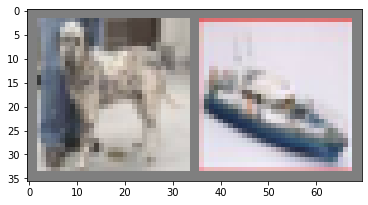

  dog  ship


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random images
dataiter = iter(data_loader)
images, labels = dataiter.next()
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(2)))

 ### Here we are chosing the device

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Here we are definig our custom NN

In [6]:
  class Model(nn.Module):
    def __init__(self):
      super(Model,self).__init__()
      self.stack = nn.Sequential(
        nn.Conv2d(3, 20, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(20, 16, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
      )
    def forward(self,x):
      return self.stack(x)

### Lets send the NN to the GPU if available

In [7]:
model = Model().to(device)
print(f"Model sent to {device}")

Model sent to cpu


### Lets prepare our custom training function

In [8]:
def train_loop(model, dataloader, loss_fn, optimizer, LOG=False):
  loss_data = []
  running_loss = 0
  for batch, data in enumerate(dataloader,0):
    inputs, label = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    prediction = model(inputs)
    loss = loss_fn(prediction, label)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if batch % 200 == 199:
      print(f"loss: {running_loss/(200)}")
      loss_data.append(running_loss/(200))
      running_loss = 0
    if batch == 20000:
      return loss_data

### Lets train our network

In [10]:
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

data = train_loop(
                model=model,
                dataloader=data_loader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                LOG=False
           )


loss: 1.599716814160347
loss: 1.6532862071692944
loss: 1.5236198486387729
loss: 1.5270167900621892
loss: 1.553229915574193
loss: 1.680911353379488
loss: 1.5724937227368354
loss: 1.4967287930846214
loss: 1.6028524823486805
loss: 1.5060488205403089
loss: 1.5571786084026098
loss: 1.516680426672101
loss: 1.542584092244506
loss: 1.6053472399711608
loss: 1.4862578020244837
loss: 1.5893384680151939
loss: 1.5435637013614179
loss: 1.5995574647188187
loss: 1.5758037207275628
loss: 1.614430694282055
loss: 1.5600126126408578
loss: 1.496970971748233
loss: 1.5796526519209146
loss: 1.4990309968590736
loss: 1.5023720921203494
loss: 1.5490922095626594
loss: 1.5471274339407683
loss: 1.5519042056798935
loss: 1.511512244194746
loss: 1.4855289410799741
loss: 1.5125232340395451
loss: 1.5917848120629787
loss: 1.5228742457553743
loss: 1.509270608574152
loss: 1.5097171440720558
loss: 1.4436422910122202
loss: 1.437813835144043
loss: 1.5533197743445635
loss: 1.474479394108057
loss: 1.4822105041891336
loss: 1.507

### We can plot the loss over time

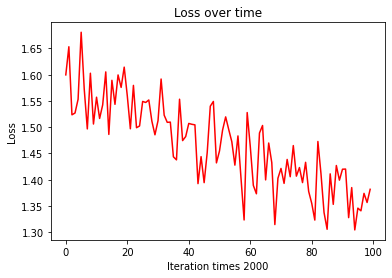

In [11]:
plt.yscale('linear')
plt.title("Loss over time")
plt.xlabel("Iteration times 2000")
plt.ylabel("Loss")
plt.plot(data, color="r")
plt.show()

### Lets show some images with computed descriptions

In [ ]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
inputs, label = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images))
result = model(inputs)
_, predicted = torch.max(result, 1)
print(predicted)
print(classes[predicted[0]],classes[predicted[1]])
print(labels)

### Lets check the performance of our model

In [ ]:
acc = 0
for batch, data in enumerate(data_loader):
    inputs, label = data
    prediction = model(inputs)
    prediction = prediction.detach().numpy()
    
    if np.argmax(prediction) == label.item():
        acc +=1

    if batch == len(data_loader)-1:
        break
        
import statistics
print(f"Performance {acc/(len(data_loader)-1)}")